In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
RANDOM_SEED = 17
torch.manual_seed(RANDOM_SEED)

In [13]:
names1 = [name.split('.')[0] for name in os.listdir('samples') if '.' in name]
names2 = [name.split('.')[0] for name in os.listdir('samples/samples') if '.' in name]

In [14]:
chars = list("".join(names1))
chars = sorted(np.unique(chars))

In [15]:
id_to_ch = {i + 1: ch for i, ch in enumerate(chars)}
id_to_ch[0] = "-"
ch_to_id = {ch: i for i, ch in id_to_ch.items()}

In [98]:
ch_to_id

{'2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 'b': 8,
 'c': 9,
 'd': 10,
 'e': 11,
 'f': 12,
 'g': 13,
 'm': 14,
 'n': 15,
 'p': 16,
 'w': 17,
 'x': 18,
 'y': 19,
 '-': 0}

In [99]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [100]:
class CaptchaDataset(torch.utils.data.Dataset):

    def __init__(self, dir_path, image_paths, transform=None, encode_table=None):
        self.dir_path = dir_path
        self.transform = transform
        self.encode_table = encode_table
        self.image_paths_id = []
        self.image_paths = image_paths
    
    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, index):
        path_to_image = self.image_paths[index]
        label = path_to_image.split('.')[0]
        if self.encode_table:
            label = torch.tensor([self.encode_table[ch] for ch in label], dtype=torch.long)

        with Image.open(self.dir_path + '/' + path_to_image).convert('RGB') as img:
            img.load()
        
        if self.transform:
            img = self.transform(img)

        return (img, label)
    



In [101]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = "samples"

image_paths = [name for name in os.listdir(data_dir) if '.' in name]

train_paths, test_paths = train_test_split(image_paths, shuffle=True, test_size=0.2, random_state=RANDOM_SEED)

batch_size = 4
num_workers = 0

trainset = CaptchaDataset(dir_path=data_dir, image_paths=train_paths, encode_table=ch_to_id, transform=transform)
testset = CaptchaDataset(dir_path=data_dir, image_paths=test_paths, encode_table=ch_to_id, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
                                    
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=num_workers)


In [102]:
len(trainset), len(testset)

(856, 214)

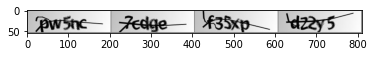

tensor([16, 17,  4, 15,  9])  tensor([ 6,  9, 10, 13, 11])  tensor([12,  2,  4, 18, 16])  tensor([10,  1,  1, 19,  4])


In [112]:
def imshow(img, labels):
    img = img / 2 + 0.5 # убираем нормализацию
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images), labels)
print('  '.join('{}'.format(labels[j]) for j in range(batch_size)))

### Модель

In [120]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.linear1 = nn.Linear(528, 64)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(64, 32, bidirectional=True, num_layers=2, dropout=0.2)
        self.linear2 = nn.Linear(64, 20)
        self.output = nn.LogSoftmax(dim=-1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))

        x = self.pool2(x)

        x = torch.flatten(x, 2)

        x = self.linear1(x)
        x = self.dropout(x)
        x, _ = self.lstm(x)
        x = self.linear2(x)
        x = self.output(x)

        log_probs = F.log_softmax(x, 2)
        input_lengths = torch.full(
            size=(batch_size, ),
            fill_value=log_probs.size(0),
            dtype=torch.int32
        )

        target_lengths = torch.full(
            size=(batch_size, ),
            fill_value=labels.size(1),
            dtype=torch.int32
        )
            
        loss = nn.CTCLoss(blank=0)(
            log_probs, labels, input_lengths, target_lengths
        )

        return x, loss

In [121]:
net = Net()

In [122]:
import torch.optim as optim

optimizer =  optim.Adam(net.parameters(), lr=1e-4)

In [123]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs, loss = net(inputs)            

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: input_lengths must be of size batch_size